# MC62 — LEAR C-shaped Dipole — `00_test` — Rotating Coil Analysis

**Magnet**: MC62 (red bulk C-shaped dipole)
**Machine**: LEAR antiproton decelerator, CERN
**Test**: `00_test` — first test RC measurement (2026-02-11)
**Current cycle**: 0 → 100 → 200 → 100 → 0 → −100 → −200 → −100 → 0 A
**PCBs**: Integral (R45, long coil) and Central (DQ, small coil), 10 turns/plateau at −60 rpm

---
**Note on the large b2**: C-shaped dipoles have inherent left-right asymmetry (open gap
on one side, iron yoke on the other). This breaks the mid-plane symmetry that an H-dipole
would have, producing a systematic quadrupole gradient (b2) across the aperture — typically
tens of units even in a well-built magnet.

## 1. Configuration

Adjust parameters below, then **Run All**.

In [ ]:
from pathlib import Path

# ── Paths ──────────────────────────────────────────────────────────────
BASE_DIR    = Path(r"C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\2026_02_11_MC62")
TEST_DIR    = BASE_DIR / "00_test" / "20260211_104646_test_REDMAGNET"
RUN_DIR     = TEST_DIR / "20260211_105610_REDMAGNET"
KN_DIR      = BASE_DIR / "Kn values"

KN_INTEGRAL = KN_DIR / "Kn_R45_PCB_N1_0001_A_AC.txt"       # integral (long) PCB
KN_CENTRAL  = KN_DIR / "Kn_DQ_5_18_7_250_47x50_0001_A_AC.txt"  # central (small) PCB

# ── Magnet & coil parameters ──────────────────────────────────────────
MAGNET_ORDER     = 1        # dipole
R_REF            = 0.033    # reference radius [m]  (2/3 of 50 mm half-gap)
SAMPLES_PER_TURN = 1024     # encoder resolution

# ── Averaging & selection ─────────────────────────────────────────────
N_LAST_TURNS = 8            # average last N turns per plateau (eddy-current settling)

# ── Sign convention ───────────────────────────────────────────────────
FLIP_FIELD_SIGN = True      # True = flip sign of all Tesla columns

# ── Pipeline options ──────────────────────────────────────────────────
OPTIONS    = ("dri", "rot", "cel", "fed")
DRIFT_MODE = "legacy"
MIN_B1_T   = 1e-6           # warm dipole: lower threshold for ok_main
MAX_ZR     = 0.01

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib widget

plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 110,
})

from rotating_coil_analyzer.analysis.kn_pipeline import load_segment_kn_txt
from rotating_coil_analyzer.analysis.utility_functions import (
    process_kn_pipeline,
    build_harmonic_rows,
    discover_runs,
    plateau_summary,
    plot_hysteresis,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

## 2. Load Kn Calibration

External Kn files — the in-test files are all zeros and are **not** used.

In [3]:
kn_integral = load_segment_kn_txt(str(KN_INTEGRAL))
kn_central  = load_segment_kn_txt(str(KN_CENTRAL))

for lbl, kn in [("Integral (R45)", kn_integral), ("Central (DQ)", kn_central)]:
    k1_abs = abs(kn.kn_abs[0])
    k1_cmp = abs(kn.kn_cmp[0])
    supp = k1_abs / max(k1_cmp, 1e-30)
    print(f"{lbl:20s}: {len(kn.orders):2d} harmonics, "
          f"k1_abs = {k1_abs:.6f}, suppression = {supp:.0f}x")

Integral (R45)      : 30 harmonics, k1_abs = 1.447495, suppression = 12924x
Central (DQ)        : 15 harmonics, k1_abs = 0.031959, suppression = 2302922349194870x


## 3. Discover and Load Raw Data

Each run is a plateau at fixed current.  Raw data columns: `[time, ch1, ch2, I_DCCT]`.
Nominal current is parsed from the filename; actual measured current from column 3 (DCCT).
Channel detection uses `robust_range` on the highest-current run to decide abs vs cmp flux.

In [ ]:
runs_integral = discover_runs(RUN_DIR, "Integral")
runs_central  = discover_runs(RUN_DIR, "Central")

print(f"Found {len(runs_integral)} integral runs, "
      f"{len(runs_central)} central runs\n")
for r in runs_integral:
    print(f"  Run {r['run_id']:02d}: I = {r['I_nom']:+8.2f} A")

## 3b. Current Profile and Turn Map

Load time and DCCT current from **all** run files (Integral PCB, since both
share the same DCCT) to build the full measurement timeline.  Each turn
is drawn as a coloured bar at its mean current level, spanning from
`t_start` to `t_end`.

In [5]:
# ── Collect per-sample time & current from all runs ────────────────────
Ns = SAMPLES_PER_TURN
t_all_samples = []
I_all_samples = []
turn_info = []  # list of dicts: t_start, t_end, I_mean, run_id, I_nom

for run_info in runs_integral:
    raw = np.loadtxt(run_info["file"])
    n_turns = raw.shape[0] // Ns
    raw = raw[: n_turns * Ns]

    t_samp = raw[:, 0]
    I_samp = raw[:, 3]
    t_all_samples.append(t_samp)
    I_all_samples.append(I_samp)

    t_2d = t_samp.reshape(n_turns, Ns)
    I_2d = I_samp.reshape(n_turns, Ns)
    for ti in range(n_turns):
        turn_info.append({
            "t_start": t_2d[ti, 0],
            "t_end":   t_2d[ti, -1],
            "I_mean":  I_2d[ti].mean(),
            "run_id":  run_info["run_id"],
            "I_nom":   run_info["I_nom"],
            "turn_in_run": ti,
        })

t_all_samples = np.concatenate(t_all_samples)
I_all_samples = np.concatenate(I_all_samples)
df_turns = pd.DataFrame(turn_info)

print(f"Timeline: {t_all_samples[0]:.1f} – {t_all_samples[-1]:.1f} s  "
      f"({len(df_turns)} turns across {df_turns['run_id'].nunique()} runs)")

Timeline: 0.0 – 3446.1 s  (90 turns across 9 runs)


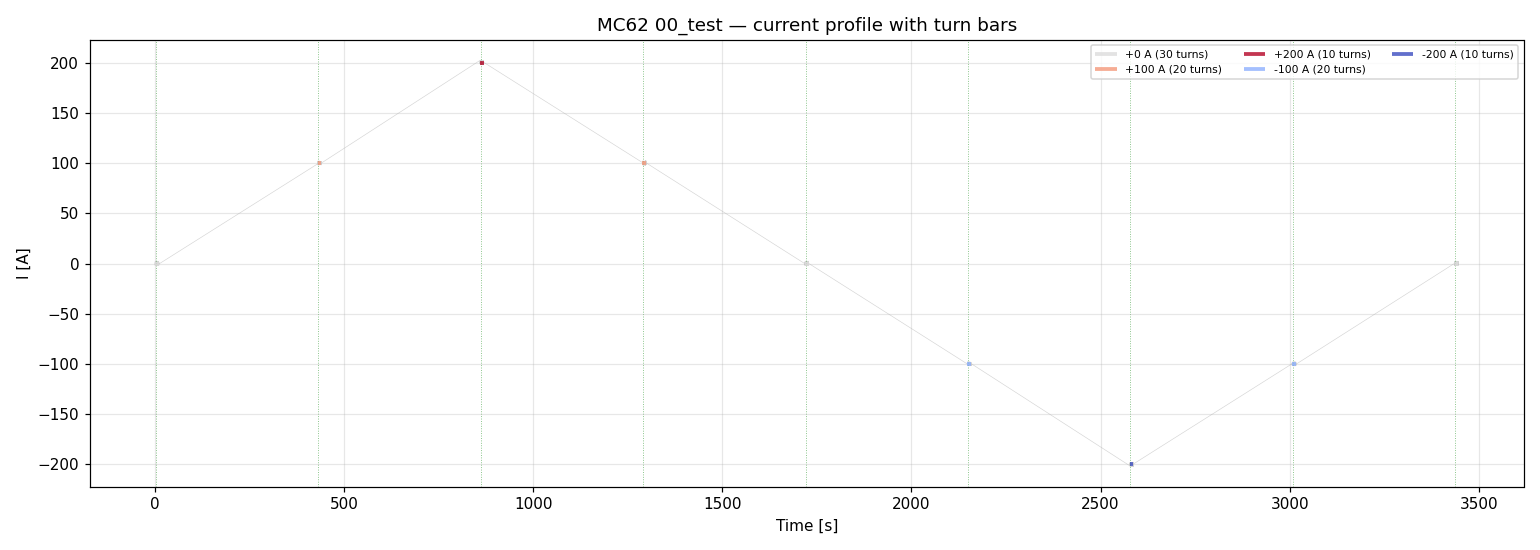

In [6]:
# ── Current profile with turn-bar overlay ──────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))

# Background: per-sample current (subsample for speed)
step = max(1, len(t_all_samples) // 80000)
ax.plot(t_all_samples[::step], I_all_samples[::step],
        linewidth=0.4, color="lightgrey", zorder=0)

# Colour palette per nominal current level
unique_I = sorted(df_turns["I_nom"].unique())
cmap = plt.cm.coolwarm
norm_c = plt.Normalize(min(unique_I), max(unique_I))
plateau_colors = {I: cmap(norm_c(I)) for I in unique_I}

# Draw each turn as a horizontal bar at its mean current
drawn_labels = set()
for _, row in df_turns.iterrows():
    I_nom = row["I_nom"]
    col = plateau_colors[I_nom]
    kw = {}
    lbl_key = f"{I_nom:+.0f} A"
    if lbl_key not in drawn_labels:
        n_at = int((df_turns["I_nom"] == I_nom).sum())
        kw["label"] = f"{lbl_key} ({n_at} turns)"
        drawn_labels.add(lbl_key)
    ax.plot([row["t_start"], row["t_end"]],
            [row["I_mean"], row["I_mean"]],
            linewidth=2.5, color=col, alpha=0.8,
            solid_capstyle="butt", zorder=2, **kw)

# Mark the "last N turns" window within each run
for run_id in df_turns["run_id"].unique():
    rdf = df_turns[df_turns["run_id"] == run_id].sort_values("turn_in_run")
    n_total = len(rdf)
    if n_total > N_LAST_TURNS:
        boundary_turn = rdf.iloc[n_total - N_LAST_TURNS]
        ax.axvline(boundary_turn["t_start"], color="green",
                   lw=0.6, ls=":", alpha=0.5, zorder=1)

ax.set_xlabel("Time [s]")
ax.set_ylabel("I [A]")
ax.set_title("MC62 00_test — current profile with turn bars")
ax.legend(loc="upper right", fontsize=7, ncol=3)
fig.tight_layout()
plt.show()

## 4. Process All Runs Through Kn Pipeline

Pipeline follows the Bottura standard (MTA-IN-97-007): drift → DFT → Kn →
centre location → feed-down → rotation → normalization → merge.

- **Integral**: `abs_upto_m_cmp_above` (B1 from absolute, n>1 from compensated)
- **Central**: `abs_all` (all from absolute — compensated SNR ≈ 3, unusable)

In [ ]:
def load_and_process_runs(runs, kn, label, merge_mode="abs_upto_m_cmp_above"):
    all_rows = []

    # Channel detection from highest-current run
    peak_run = max(runs, key=lambda r: abs(r["I_nom"]))
    raw_peak = np.loadtxt(peak_run["file"])
    rr1 = robust_range(raw_peak[:, 1])
    rr2 = robust_range(raw_peak[:, 2])
    swap = rr2 > rr1
    print(f"[{label}] col1 range={rr1:.3e}, col2 range={rr2:.3e}"
          f"  ->  {'SWAP' if swap else 'no swap'}"
          f"  |  merge: {merge_mode}")

    # Hysteresis branch direction
    I_noms = [r["I_nom"] for r in runs]
    branches = ["ascending"]
    for i in range(1, len(I_noms)):
        if I_noms[i] > I_noms[i - 1]:
            branches.append("ascending")
        elif I_noms[i] < I_noms[i - 1]:
            branches.append("descending")
        else:
            branches.append(branches[-1])

    for ri, run_info in enumerate(runs):
        raw = np.loadtxt(run_info["file"])
        n_turns = raw.shape[0] // Ns
        raw = raw[: n_turns * Ns]

        t_turns  = raw[:, 0].reshape(n_turns, Ns)
        ch1      = raw[:, 1].reshape(n_turns, Ns)
        ch2      = raw[:, 2].reshape(n_turns, Ns)
        flux_abs = ch2 if swap else ch1
        flux_cmp = ch1 if swap else ch2
        # Column 3 is DCCT current (already in Amperes)
        I_turns  = raw[:, 3].reshape(n_turns, Ns)

        try:
            result, C_merged, C_units, ok_main = process_kn_pipeline(
                flux_abs, flux_cmp, t_turns, I_turns, kn, R_REF,
                MAGNET_ORDER,
                options=OPTIONS, drift_mode=DRIFT_MODE,
                min_b1_T=MIN_B1_T, max_zr=MAX_ZR,
                merge_mode=merge_mode,
            )
            extra = [{"run_id": run_info["run_id"],
                       "I_nom": run_info["I_nom"],
                       "branch": branches[ri],
                       "turn_in_run": t,
                       "pcb": label}
                      for t in range(n_turns)]
            rows = build_harmonic_rows(
                result, C_merged, C_units, ok_main,
                MAGNET_ORDER, extra)
            all_rows.extend(rows)
            n_ok = int(sum(ok_main))
            I_actual = I_turns.mean()
            print(f"  Run {run_info['run_id']:02d} "
                  f"(I_nom={run_info['I_nom']:+7.1f} A, "
                  f"I_meas={I_actual:+7.1f} A): "
                  f"{n_turns} turns, {n_ok} ok")
        except Exception as e:
            print(f"  Run {run_info['run_id']:02d} "
                  f"({run_info['I_nom']:+7.1f} A): FAILED - {e}")

    return pd.DataFrame(all_rows)

print("Processing Integral PCB (R45)...")
df_int = load_and_process_runs(runs_integral, kn_integral, "Integral")
print(f"\nProcessing Central PCB (DQ) — merge_mode='abs_all' (cmp SNR too low)...")
df_cen = load_and_process_runs(runs_central, kn_central, "Central",
                               merge_mode="abs_all")

# ── Sign convention ────────────────
if FLIP_FIELD_SIGN:
    for _df in [df_int, df_cen]:
        abs_cols = [c for c in _df.columns if c.endswith("_T")]
        _df[abs_cols] *= -1
    print("\n[Sign flip applied to Tesla columns]")

print(f"\nIntegral: {len(df_int)} rows  |  Central: {len(df_cen)} rows")

## 5. Plateau Quality & Averaging

Select the **last N turns** per plateau (to let eddy currents settle).
Flag plateaus as *good* or *bad* based on `ok_main`.

In [ ]:
summ_int = plateau_summary(df_int, N_LAST_TURNS)
summ_cen = plateau_summary(df_cen, N_LAST_TURNS)

cols_show = ["run_id", "I_nom", "branch", "n_ok",
             "B1_mean", "B1_std", "quality"]
print("=== Integral PCB (R45) ===")
print(summ_int[cols_show].to_string(index=False, float_format="%.6f"))
print(f"\n=== Central PCB (DQ) ===")
print(summ_cen[cols_show].to_string(index=False, float_format="%.6f"))

## 6. Eddy-Current Settling — B1 vs Turn Number

Turn-by-turn evolution within each plateau.  The grey dashed line marks
the boundary of the **last N turns** selection window.

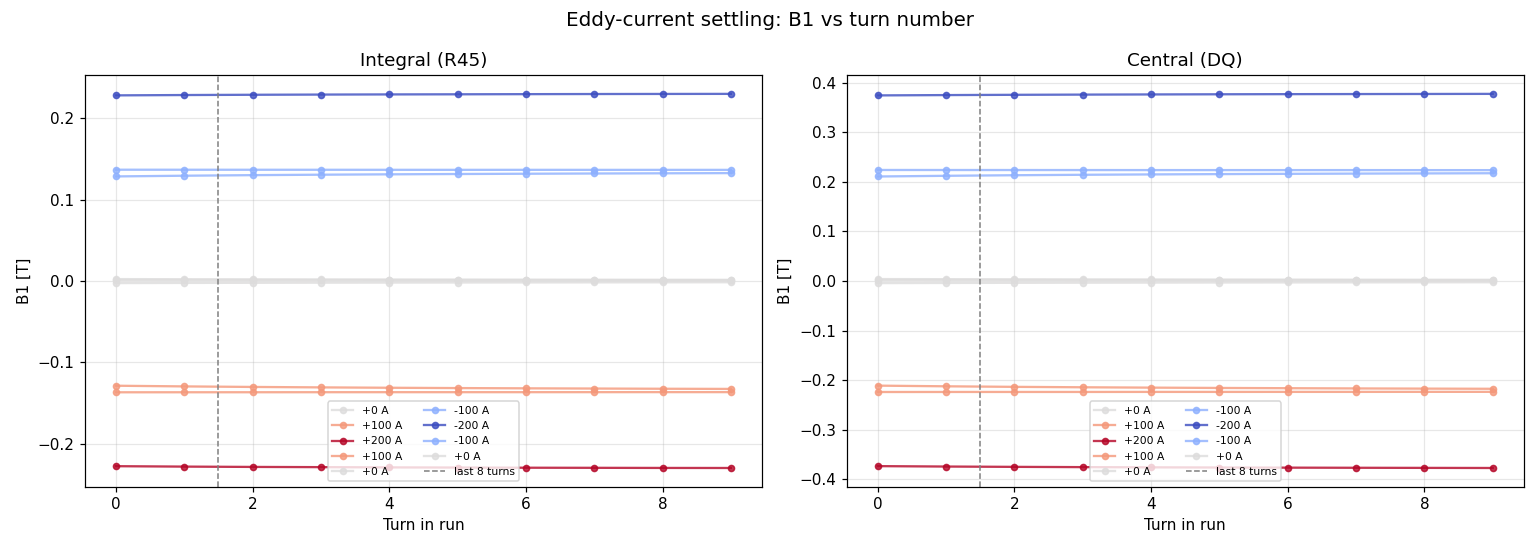

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, df, label in [(axes[0], df_int, "Integral (R45)"),
                       (axes[1], df_cen, "Central (DQ)")]:
    cmap = plt.cm.coolwarm
    all_runs = sorted(df["run_id"].unique())
    I_min = df["I_nom"].min()
    I_max = df["I_nom"].max()
    norm = plt.Normalize(I_min, I_max)

    for run_id in all_runs:
        rdf = df[df["run_id"] == run_id].sort_values("turn_in_run")
        ok = rdf["ok_main"].astype(bool)
        if not ok.any():
            continue
        I_nom = rdf["I_nom"].iloc[0]
        color = cmap(norm(I_nom))
        ax.plot(rdf.loc[ok, "turn_in_run"], rdf.loc[ok, "B1_T"],
                "o-", ms=4, color=color, alpha=0.8,
                label=f"{I_nom:+.0f} A")

    n_total_max = df.groupby("run_id")["turn_in_run"].max().max()
    ax.axvline(x=n_total_max - N_LAST_TURNS + 0.5,
               ls="--", color="gray", lw=1,
               label=f"last {N_LAST_TURNS} turns")
    ax.set_xlabel("Turn in run")
    ax.set_ylabel("B1 [T]")
    ax.set_title(label)
    ax.legend(fontsize=7, ncol=2)

fig.suptitle("Eddy-current settling: B1 vs turn number", fontsize=13)
fig.tight_layout()
plt.show()

## 7. B1 (Main Dipole Field) vs Current — Hysteresis

Averaged over last N turns.  **Blue** = ascending, **Red** = descending.
Grey arrows show the measurement traversal order (the "direction of going").

In [ ]:
branch_colors = {"ascending": "tab:blue", "descending": "tab:red"}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "B1_mean", "B1_std")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("B1 [T]")
    ax.set_title(label)
    ax.legend(fontsize=7, ncol=2)
    ax.axhline(0, color="gray", lw=0.5)
    ax.axvline(0, color="gray", lw=0.5)

fig.suptitle(f"B1 vs Current (last {N_LAST_TURNS} turns averaged)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 8. b2 (Quadrupole) vs Current

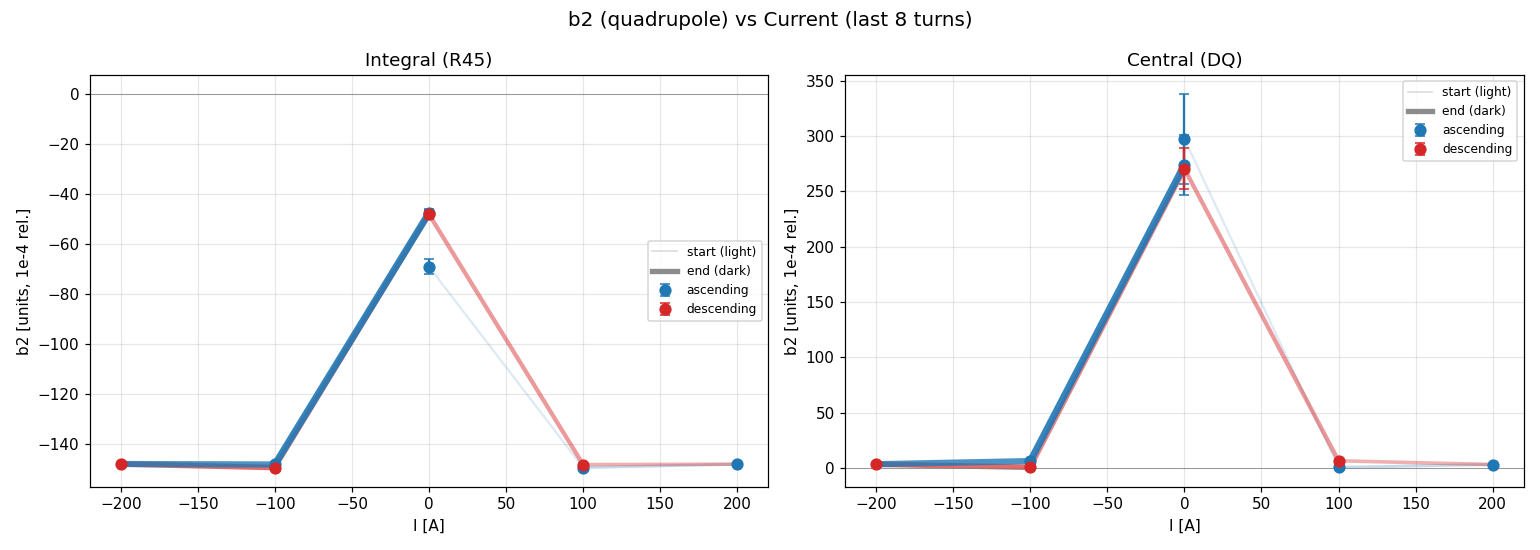

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "b2_units_mean", "b2_units_std")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("b2 [units, 1e-4 rel.]")
    ax.set_title(label)
    ax.legend(fontsize=8)
    ax.axhline(0, color="gray", lw=0.5)

fig.suptitle(f"b2 (quadrupole) vs Current (last {N_LAST_TURNS} turns)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 9. b3 (Sextupole) vs Current

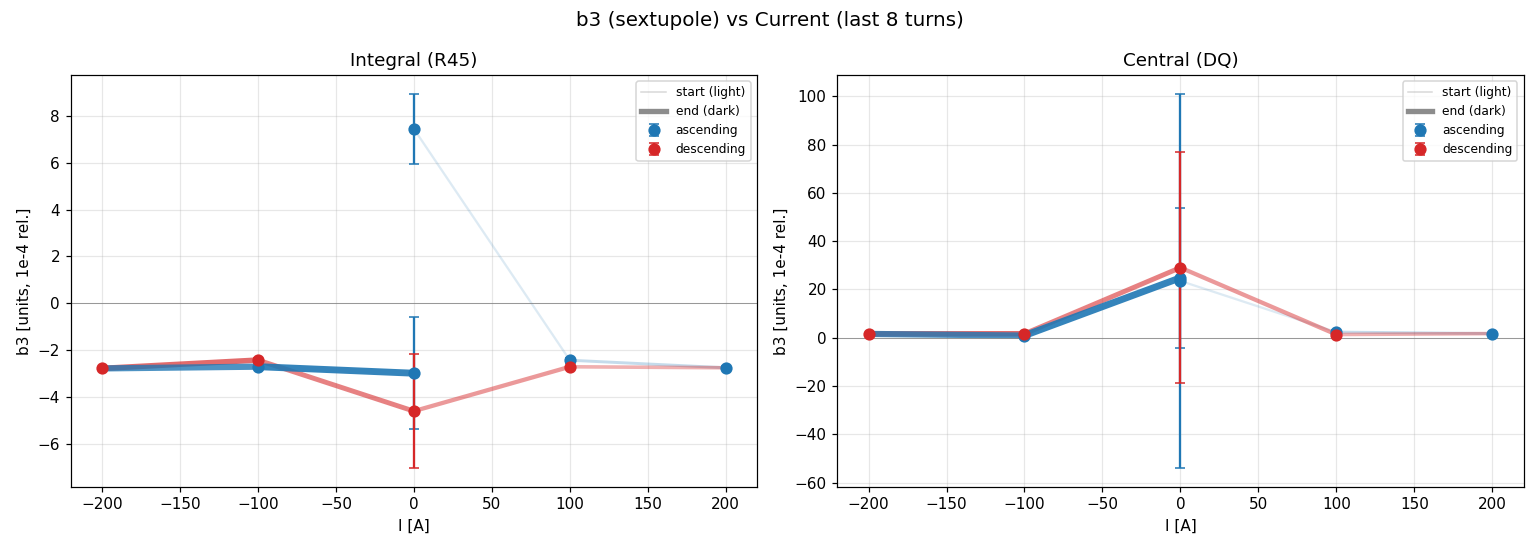

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "b3_units_mean", "b3_units_std")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("b3 [units, 1e-4 rel.]")
    ax.set_title(label)
    ax.legend(fontsize=8)
    ax.axhline(0, color="gray", lw=0.5)

fig.suptitle(f"b3 (sextupole) vs Current (last {N_LAST_TURNS} turns)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 10. Transfer Function  B1 / I  vs I

Excludes 0 A runs (undefined).  Saturation appears as a drop in TF at
high |I|.

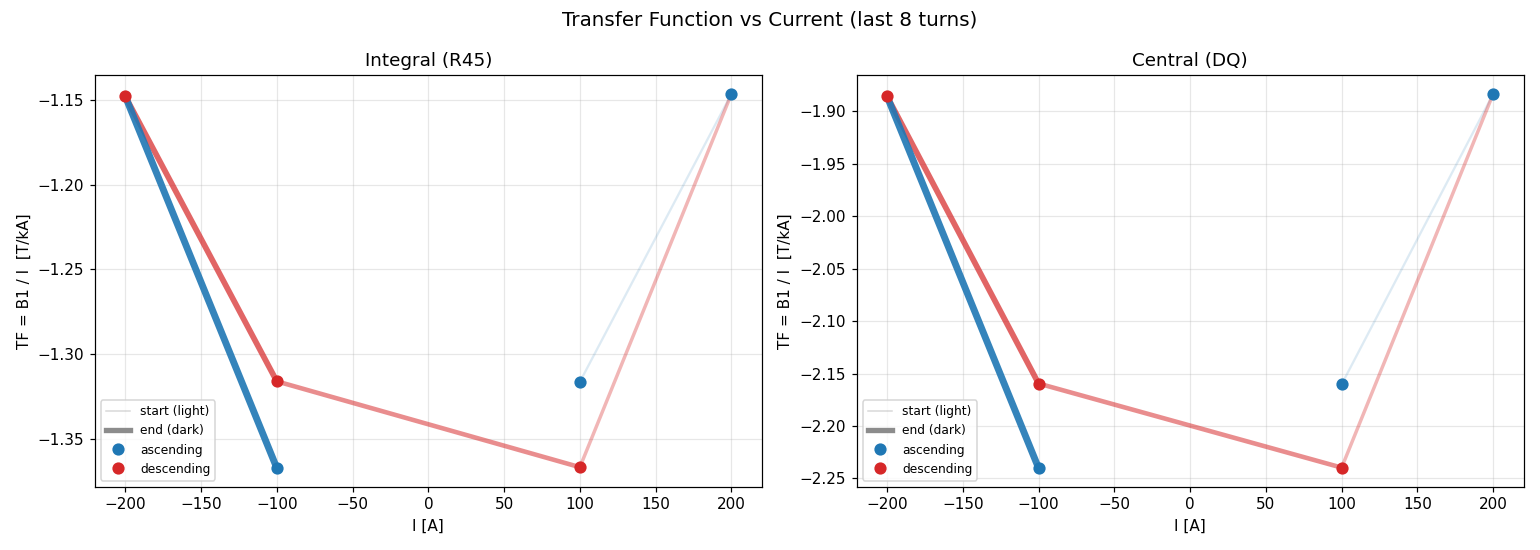

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "TF")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("TF = B1 / I  [T/kA]")
    ax.set_title(label)
    ax.legend(fontsize=8)

fig.suptitle(f"Transfer Function vs Current (last {N_LAST_TURNS} turns)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 11. Multipole Spectrum at Peak Current

Bar chart of normal (bn) and skew (an) harmonics at the
highest-current good plateau.

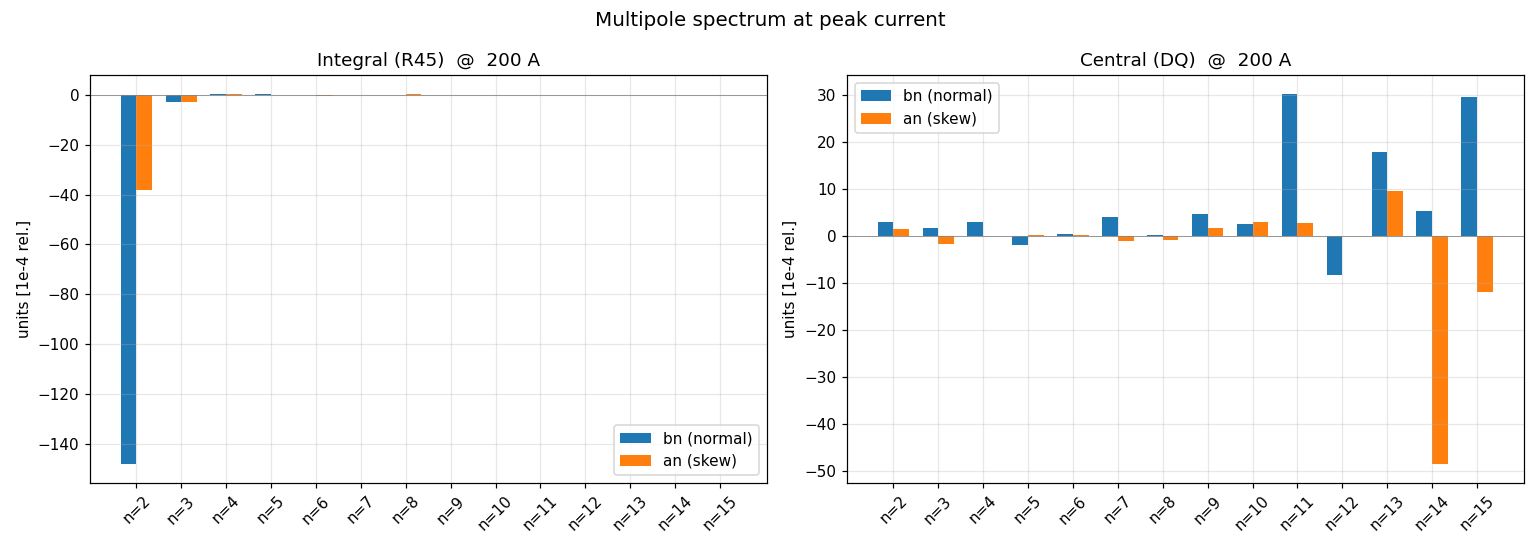

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    # Pick highest |I| good plateau
    good = summ[summ["quality"] == "good"]
    if good.empty:
        ax.set_title(f"{label}: no valid data")
        continue
    peak = good.loc[good["I_nom"].abs().idxmax()]

    orders, bn, an = [], [], []
    for n in range(2, 16):
        bc = f"b{n}_units_mean"
        ac = f"a{n}_units_mean"
        if bc in summ.columns and pd.notna(peak.get(bc)):
            orders.append(n)
            bn.append(peak[bc])
            an.append(peak.get(ac, 0.0) if pd.notna(peak.get(ac)) else 0.0)

    if orders:
        x = np.arange(len(orders))
        w = 0.35
        ax.bar(x - w / 2, bn, w, label="bn (normal)", color="tab:blue")
        ax.bar(x + w / 2, an, w, label="an (skew)", color="tab:orange")
        ax.set_xticks(x)
        ax.set_xticklabels([f"n={o}" for o in orders], rotation=45)
        ax.set_ylabel("units [1e-4 rel.]")
        ax.set_title(f"{label}  @  {peak['I_nom']:.0f} A")
        ax.legend()
        ax.axhline(0, color="gray", lw=0.5)

fig.suptitle("Multipole spectrum at peak current", fontsize=13)
fig.tight_layout()
plt.show()

## 12. Summary Table

In [15]:
def format_summary(summ, label):
    print(f"\n{'=' * 85}")
    print(f"  {label}")
    print(f"  R_ref = {R_REF*1e3:.1f} mm  |  "
          f"last {N_LAST_TURNS} turns averaged")
    print(f"{'=' * 85}")
    hdr = (f"{'Run':>4s} {'I [A]':>8s} {'Branch':>10s} "
           f"{'B1 [T]':>12s} {'b2 [units]':>12s} "
           f"{'b3 [units]':>12s} {'TF [T/kA]':>10s} {'Qual':>5s}")
    print(hdr)
    print("-" * 85)
    for _, r in summ.iterrows():
        b1 = f"{r['B1_mean']:.6f}" if pd.notna(r['B1_mean']) else "---"
        b2 = (f"{r.get('b2_units_mean', np.nan):.2f}"
              if pd.notna(r.get('b2_units_mean')) else "---")
        b3 = (f"{r.get('b3_units_mean', np.nan):.2f}"
              if pd.notna(r.get('b3_units_mean')) else "---")
        tf = f"{r['TF']:.4f}" if pd.notna(r['TF']) else "---"
        print(f"{r['run_id']:4.0f} {r['I_nom']:+8.1f} "
              f"{r['branch']:>10s} {b1:>12s} {b2:>12s} "
              f"{b3:>12s} {tf:>10s} {r['quality']:>5s}")

format_summary(summ_int, "Integral PCB (R45)")
format_summary(summ_cen, "Central PCB (DQ)")


  Integral PCB (R45)
  R_ref = 33.0 mm  |  last 8 turns averaged
 Run    I [A]     Branch       B1 [T]   b2 [units]   b3 [units]  TF [T/kA]  Qual
-------------------------------------------------------------------------------------
   0     +0.0  ascending     0.001120       -69.21         7.44        ---  good
   1   +100.0  ascending    -0.131624      -149.60        -2.43    -1.3162  good
   2   +200.0  ascending    -0.229322      -148.24        -2.75    -1.1466  good
   3   +100.0 descending    -0.136651      -148.41        -2.71    -1.3665  good
   4     +0.0 descending    -0.001818       -48.22        -4.60        ---  good
   5   -100.0 descending     0.131594      -149.60        -2.42    -1.3159  good
   6   -200.0 descending     0.229604      -148.17        -2.78    -1.1480  good
   7   -100.0  ascending     0.136698      -148.37        -2.70    -1.3670  good
   8     +0.0  ascending     0.001754       -47.64        -2.98        ---  good

  Central PCB (DQ)
  R_ref = 33.0 mm 

## 13. Export to CSV (optional)

In [16]:
# Uncomment to save:
# out = Path(r"C:\Users\albellel\python-projects\rotating-coil-analyzer\output")
# out.mkdir(exist_ok=True)
# summ_int.to_csv(out / "MC62_00_test_integral_summary.csv", index=False)
# summ_cen.to_csv(out / "MC62_00_test_central_summary.csv", index=False)
# df_int.to_csv(out / "MC62_00_test_integral_all_turns.csv", index=False)
# df_cen.to_csv(out / "MC62_00_test_central_all_turns.csv", index=False)
# print("Saved to", out)